# MIMIC Preprocessed EDA

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from recurrent_health_events_prediction.visualization.utils import plot_patients_hospitalizations
from recurrent_health_events_prediction.eda.utils import compare_distributions
from recurrent_health_events_prediction.model.model_types import DistributionType

event_type_censoring_color_map = {
    "Event Ocurred": px.colors.qualitative.Plotly[1],
    "Censored": px.colors.qualitative.Plotly[0]
}

event_type_color_map = {
    'Hosp. with Readmission after Discharge': px.colors.qualitative.Plotly[0],
    'Hosp. with In-Hospital Death': px.colors.qualitative.Plotly[1],
    'Hosp. with Death After Hospital Discharge': px.colors.qualitative.Plotly[2],
    'Hosp. with No Readmission or No Death after Discharge': px.colors.qualitative.Plotly[4]
}

MULTIPLE_HOSP_PATIENTS = False

### Import Data

In [77]:
from importlib import resources as impresources
from recurrent_health_events_prediction import configs
import yaml

with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

In [78]:
training_data_config = data_config["training_data"]["mimic"]
training_data_path = training_data_config["preprocessed_output_path_1st_round"]
if MULTIPLE_HOSP_PATIENTS:
    training_data_path += '/multiple_hosp_patients'
print(f"Loading training data from {training_data_path}")

Loading training data from /workspaces/msc-thesis-recurrent-health-modeling/data/mimic-iii-preprocessed/copd_hf_renal_diabetes


In [79]:
all_events_patient_plot_df = pd.read_csv(training_data_path+ "/all_events.csv")
all_events_patient_plot_df['ADMITTIME'] = pd.to_datetime(all_events_patient_plot_df['ADMITTIME'])
all_events_patient_plot_df['DISCHTIME'] = pd.to_datetime(all_events_patient_plot_df['DISCHTIME'])
all_events_patient_plot_df['DOD'] = pd.to_datetime(all_events_patient_plot_df['DOD'])

In [80]:
all_events_df = pd.read_csv(training_data_path + "/all_events.csv")
all_events_df['ADMITTIME'] = pd.to_datetime(all_events_df['ADMITTIME'])
all_events_df['DISCHTIME'] = pd.to_datetime(all_events_df['DISCHTIME'])
all_events_df['DOD'] = pd.to_datetime(all_events_df['DOD'])

In [81]:
all_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17606 entries, 0 to 17605
Data columns (total 57 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   SUBJECT_ID                            17606 non-null  int64         
 1   HADM_ID                               17606 non-null  int64         
 2   ADMITTIME                             17606 non-null  datetime64[ns]
 3   DISCHTIME                             17606 non-null  datetime64[ns]
 4   ADMISSION_TYPE                        17606 non-null  object        
 5   ETHNICITY                             17606 non-null  object        
 6   DISCHARGE_LOCATION                    17606 non-null  object        
 7   INSURANCE                             17606 non-null  object        
 8   HOSPITALIZATION_DAYS                  17606 non-null  float64       
 9   NUM_COMORBIDITIES                     17606 non-null  int64         
 10

In [82]:
last_events_df = pd.read_csv(training_data_path + "/last_events.csv")
last_events_df['ADMITTIME'] = pd.to_datetime(last_events_df['ADMITTIME'])
last_events_df['DISCHTIME'] = pd.to_datetime(last_events_df['DISCHTIME'])
last_events_df['DOD'] = pd.to_datetime(last_events_df['DOD'])

In [83]:
historical_events_df = all_events_df[all_events_df['IS_HISTORICAL_EVENT'] == 1].copy()

In [84]:
def classify_event(row):
    if row['READMISSION_EVENT'] == 1:
        return 'Hosp. with Readmission after Discharge'
    elif row['IN_HOSP_DEATH_EVENT'] == 1:
        return 'In-Hospital Death'
    elif row['AFTER_HOSP_DEATH_EVENT'] == 1:
        return 'Hosp. with Death After Hospital Discharge'
    else:
        return 'Hosp. with No Readmission or No Death after Discharge'

all_events_df['EVENT_TYPE'] = all_events_df.apply(classify_event, axis=1)
last_events_df['EVENT_TYPE'] = last_events_df.apply(classify_event, axis=1)
all_events_patient_plot_df['EVENT_TYPE'] = all_events_patient_plot_df.apply(classify_event, axis=1)
historical_events_df['EVENT_TYPE'] = historical_events_df.apply(classify_event, axis=1)

### Checking data consistency

In [85]:
last_events_df[["EVENT_DURATION", "READMISSION_EVENT", "NUM_PREV_HOSPITALIZATIONS"]].describe()

EVENT_DURATION  READMISSION_EVENT  NUM_PREV_HOSPITALIZATIONS
count    13533.000000       13533.000000               13533.000000
mean       106.259307           0.166630                   0.300968
std         33.451038           0.372659                   1.152025
min          1.004167           0.000000                   0.000000
25%        120.000000           0.000000                   0.000000
50%        120.000000           0.000000                   0.000000
75%        120.000000           0.000000                   0.000000
max        120.000000           1.000000                  40.000000

In [86]:
assert all_events_df["EVENT_DURATION"].min() >= 0, "Event durations should be non-negative."
assert all_events_df["PARTICIPATION_DAYS"].min() >= 0, "Participation days should be non-negative."
assert all_events_df["TOTAL_PARTICIPATION_DAYS"].min() >= 0, "Total participation days should be non-negative."
assert all_events_df["PARTICIPATION_DAYS"].max() <= all_events_df["TOTAL_PARTICIPATION_DAYS"].max(), "Participation days should not exceed total participation days."
assert all_events_df["EVENT_DURATION"].max() <= training_data_config["censoring_limit"], "Event duration should not exceed upper limit."

### Inspect Patient History

In [87]:
subject_id = 433
plot_patients_hospitalizations(
    all_events_patient_plot_df,
    subject_ids=[323, 357, 402, 433, 518],
    additional_hover_cols=[
        "EVENT_TYPE",
        "DAYS_UNTIL_NEXT_HOSPITALIZATION",
        "TYPES_COMORBIDITIES",
        "ADMISSION_TYPE",
        "TOTAL_HOSPITALIZATIONS",
    ],
    color_map=event_type_color_map,
    color_col="EVENT_TYPE",
)
mask = all_events_df["SUBJECT_ID"] == subject_id
all_events_df[mask]

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
160         433   120589 2162-01-18 11:32:00 2162-02-08 18:55:00   
161         433   141626 2163-10-08 15:51:00 2163-10-28 19:52:00   
162         433   172593 2164-03-06 20:55:00 2164-04-11 11:50:00   

    ADMISSION_TYPE               ETHNICITY        DISCHARGE_LOCATION  \
160      EMERGENCY  BLACK/AFRICAN AMERICAN  REHAB/DISTINCT PART HOSP   
161      EMERGENCY  BLACK/AFRICAN AMERICAN  REHAB/DISTINCT PART HOSP   
162      EMERGENCY  BLACK/AFRICAN AMERICAN          HOME HEALTH CARE   

    INSURANCE  HOSPITALIZATION_DAYS  NUM_COMORBIDITIES  ...  \
160  Medicaid             21.307639                  2  ...   
161  Medicaid             20.167361                  3  ...   
162  Medicaid             35.621528                  4  ...   

    LOG_HOSPITALIZATION_DAYS  LOG_DAYS_IN_ICU  LOG_NUM_PREV_HOSPITALIZATIONS  \
160                 3.104929         1.630891                       0.000000   
161                 3.052460         2.193862                       0.693147   
162                 3.600636         1.650820                       1.098612   

     LOG_PARTICIPATION_DAYS LOG_NUM_DRUGS  IS_LAST_EVENT IS_HISTORICAL_EVENT  \
160                3.091042      3.806662              0                   1   
161                6.475433      3.784190              0                   1   
162                6.703188      3.970292              1                   0   

    READMISSION_TIME_CAT  READMISSION_TIME_CAT_ENCODED  \
160                 120+                             2   
161                 120+                             2   
162                 120+                             2   

                                            EVENT_TYPE  
160  Hosp. with No Readmission or No Death after Di...  
161  Hosp. with No Readmission or No Death after Di...  
162  Hosp. with No Readmission or No Death after Di...  

[3 rows x 58 columns]

## All Events

In [88]:
print("Number of subjects: ", all_events_df["SUBJECT_ID"].nunique())

Number of subjects:  13533


### Distribution of Readmission Time Category

In [89]:
px.pie(
    all_events_df,
    names="READMISSION_TIME_CAT",
    title="Distribution of Readmission Time Categories (Days)",
    labels={"READMISSION_TIME_CAT": "Readmission Time Category"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600,
).show()

### Distribution of Admisison Type

In [90]:
px.pie(
    all_events_df,
    names="ADMISSION_TYPE",
    title=f"Admission Type Proportions",
    labels={"ADMISSION_TYPE": "Admission Type"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600
).show()

### Diseases Distribution

In [91]:
fig = px.histogram(all_events_df, x='NUM_COMORBIDITIES', title='Distribution of Number of Comorbidities - All Readmission Events', width=800, height=400, nbins=50)
fig.update_layout(xaxis_title='Number of Comorbidities', yaxis_title='Count')
fig.show()

In [92]:
diseases_all_events_df = all_events_df[['SUBJECT_ID', 'TYPES_COMORBIDITIES']].copy()
diseases_all_events_df.head()

SUBJECT_ID                                TYPES_COMORBIDITIES
0           6                         ['other', 'renal_disease']
1          21  ['myocardial_infarct', 'other', 'cerebrovascul...
2          26  ['other', 'congestive_heart_failure', 'myocard...
3          28  ['other', 'diabetes_without_cc', 'myocardial_i...
4          30              ['other', 'congestive_heart_failure']

In [93]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# If your column is still strings, convert to list first
diseases_all_events_df['TYPES_COMORBIDITIES'] = diseases_all_events_df['TYPES_COMORBIDITIES'].apply(ast.literal_eval)

# Now one-hot encode the comorbidities
mlb = MultiLabelBinarizer()
disease_ohe = mlb.fit_transform(diseases_all_events_df['TYPES_COMORBIDITIES'])

# Create a DataFrame with patient IDs as index and disease columns
disease_df = pd.DataFrame(disease_ohe, 
                          columns=mlb.classes_, 
                          index=diseases_all_events_df['SUBJECT_ID'])

# Now you can see the matrix you described
disease_df.head()

aids  cerebrovascular_disease  chronic_pulmonary_disease  \
SUBJECT_ID                                                             
6              0                        0                          0   
21             0                        1                          0   
26             0                        0                          0   
28             0                        0                          1   
30             0                        0                          0   

            congestive_heart_failure  dementia  diabetes_with_cc  \
SUBJECT_ID                                                         
6                                  0         0                 0   
21                                 1         0                 0   
26                                 1         0                 0   
28                                 0         0                 0   
30                                 1         0                 0   

            diabetes_without_cc  malignant_cancer  metastatic_solid_tumor  \
SUBJECT_ID                                                                  
6                             0                 0                       0   
21                            1                 0                       0   
26                            0                 0                       0   
28                            1                 0                       0   
30                            0                 0                       0   

            mild_liver_disease  myocardial_infarct  other  paraplegia  \
SUBJECT_ID                                                              
6                            0                   0      1           0   
21                           0                   1      1           0   
26                           0                   1      1           0   
28                           0                   1      1           0   
30                           0                   0      1           0   

            peptic_ulcer_disease  peripheral_vascular_disease  renal_disease  \
SUBJECT_ID                                                                     
6                              0                            0              1   
21                             0                            0              1   
26                             0                            0              0   
28                             0                            0              0   
30                             0                            0              0   

            rheumatic_disease  severe_liver_disease  
SUBJECT_ID                                           
6                           0                     0  
21                          0                     0  
26                          0                     0  
28                          0                     0  
30                          0                     0

In [94]:
disease_counts = disease_df.sum().sort_values(ascending=False)

px.bar(disease_counts,
    title='Total Number of Patients with Each Disease - All Readmission Events',
    labels={'index': 'Disease', 'value': 'Number of Patients'},
    width=1200,
    height=400
).update_layout(xaxis_title='Disease', yaxis_title='Number of Patients').show()

### Distribution of Event Types

In [95]:
px.pie(
       all_events_df,
       names='EVENT_TYPE',
       title='Distribution of Event Types in All Events',
       color='EVENT_TYPE',
       width=800,
       height=400,
       color_discrete_map=event_type_color_map
).show()

In [96]:
fig = px.pie(all_events_df["READMISSION_EVENT"].map(lambda x: "Event Ocurred" if x == 1 else "Censored"),
       names='READMISSION_EVENT',
       title='Proportion of Censored Readmission Events in All Events',
       color='READMISSION_EVENT',
       labels={'READMISSION_EVENT': 'Observed Readmission'},
       width=800,
       height=400,
       color_discrete_map=event_type_censoring_color_map)
# Display the figure
fig.show()

### Distribution of Participation Days

In [97]:
participation_df = all_events_df.groupby("SUBJECT_ID")[["TOTAL_PARTICIPATION_DAYS", "EVENT_TYPE", "NUM_PREV_HOSPITALIZATIONS"]].last().reset_index()
participation_df.head()

SUBJECT_ID  TOTAL_PARTICIPATION_DAYS  \
0           6                        16   
1          21                       149   
2          26                       659   
3          28                         5   
4          30                         5   

                                          EVENT_TYPE  \
0  Hosp. with No Readmission or No Death after Di...   
1  Hosp. with No Readmission or No Death after Di...   
2          Hosp. with Death After Hospital Discharge   
3  Hosp. with No Readmission or No Death after Di...   
4  Hosp. with No Readmission or No Death after Di...   

   NUM_PREV_HOSPITALIZATIONS  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0

In [98]:
participation_df["TOTAL_PARTICIPATION_DAYS"].describe()

count    13533.000000
mean       541.770117
std        835.087470
min          1.000000
25%          7.000000
50%         37.000000
75%        814.000000
max       4332.000000
Name: TOTAL_PARTICIPATION_DAYS, dtype: float64

In [99]:
participation_days_binned_count_s = pd.cut(
    participation_df["TOTAL_PARTICIPATION_DAYS"],
    right=True,
    bins=[0, 180, 365, 730, 1460, np.inf],
    labels=["0--180 days", "181--365 days", "1--2 years", "2--4 years", "4+ years"]
).value_counts(normalize=True).sort_index() * 100

participation_days_binned_count_s = participation_days_binned_count_s.reset_index()
participation_days_binned_count_s.columns = ["Participation Days", "Percentage"]
participation_days_binned_count_s

Participation Days  Percentage
0        0--180 days   58.139363
1      181--365 days    4.514890
2         1--2 years   10.411586
3         2--4 years   12.547107
4           4+ years   14.387054

In [100]:
overall_median_participation_days = participation_df["TOTAL_PARTICIPATION_DAYS"].median()
num_participants_less_than_30_days = (participation_df["TOTAL_PARTICIPATION_DAYS"] < 30).sum()
num_participants_less_than_10_days = (participation_df["TOTAL_PARTICIPATION_DAYS"] < 10).sum()
print(f"Number of participants with less than 30 days of participation: {num_participants_less_than_30_days}")
print(f"Overall median participation days: {overall_median_participation_days}")
print(f"Number of participants with less than 10 days of participation: {num_participants_less_than_10_days}")

Number of participants with less than 30 days of participation: 6582
Overall median participation days: 37.0
Number of participants with less than 10 days of participation: 4583


In [101]:
fig = px.histogram(participation_df, "TOTAL_PARTICIPATION_DAYS", nbins=80)
fig.update_layout(
    title="Distribution of Participation Time in the Study",
    width=1000,
    height=400,
    bargap=0.05,
)
fig.update_xaxes(title_text="Total Participation Days", dtick=100, )
fig.update_yaxes(title_text="Number of Patients")
fig.show()

In [102]:
fig = px.histogram(participation_df, "TOTAL_PARTICIPATION_DAYS", facet_col="EVENT_TYPE", nbins=50, color="EVENT_TYPE", color_discrete_map=event_type_color_map)
fig.update_layout(
    title="Distribution of Estimated Participation Time in the Study"
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

#### Examples - Short Total Participation Days

In [103]:
subjects_ids = [29080, 88254, 63442, 1547, 3871]


In [104]:
plot_patients_hospitalizations(all_events_df, subject_ids=subjects_ids,
                               additional_hover_cols=['EVENT_TYPE', 'NUM_PREV_HOSPITALIZATIONS', 'DAYS_UNTIL_NEXT_HOSPITALIZATION'],
                               color_map=event_type_color_map, color_col='EVENT_TYPE', max_number_days=30)

### Distribution of Event Duration

#### Observed Readmissions

In [105]:
all_observed_readmissions_df = all_events_df[all_events_df["READMISSION_EVENT"] == 1]
all_observed_readmissions_df["EVENT_DURATION"].describe()

count    4283.000000
mean       38.303865
std        32.046879
min         1.004167
25%        10.933681
50%        29.208333
75%        59.370833
max       119.997222
Name: EVENT_DURATION, dtype: float64

In [106]:
import plotly.express as px

fig = px.histogram(all_observed_readmissions_df, x='EVENT_DURATION', title='Distribution of Time to Observed Readmissions', width=1200, height=400)
fig.update_layout(xaxis_title='Time to Readmission Event', yaxis_title='Count')
fig.show()

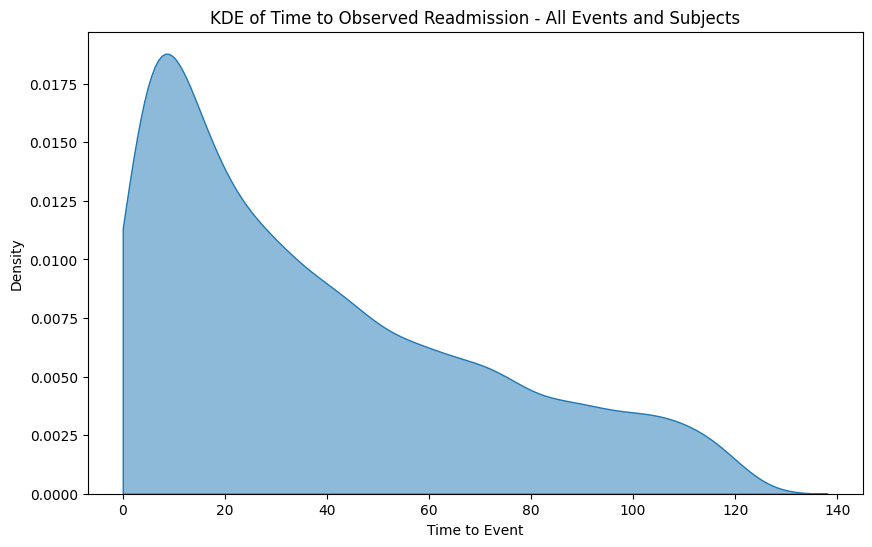

In [107]:
all_observed_readmissions_df = all_events_df[all_events_df["READMISSION_EVENT"] == 1]
plt.figure(figsize=(10, 6))

sns.kdeplot(data=all_observed_readmissions_df, x='EVENT_DURATION', alpha=0.5, fill=True, clip=(0, None))

plt.title('KDE of Time to Observed Readmission - All Events and Subjects')
plt.xlabel('Time to Event')
plt.ylabel('Density')
plt.show()

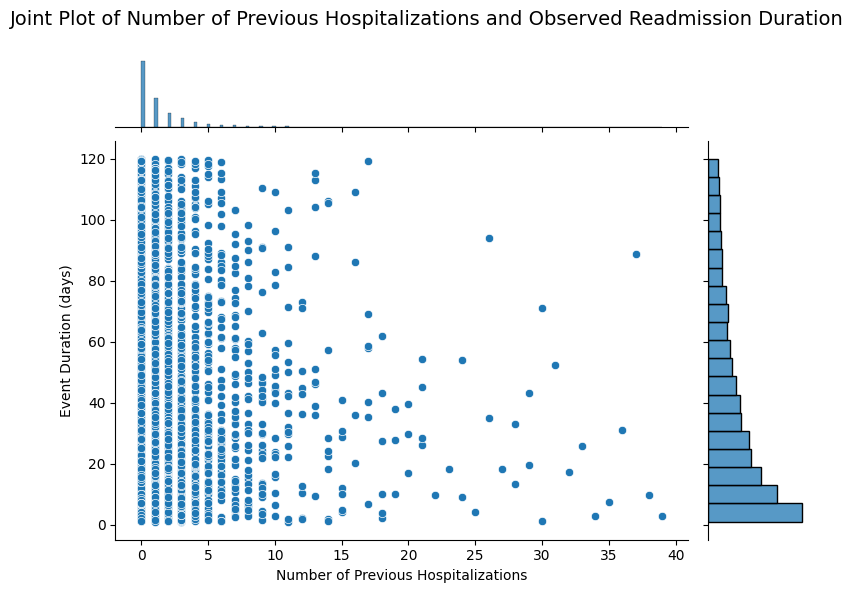

In [108]:
sns.jointplot(
    data=all_observed_readmissions_df,
    x='NUM_PREV_HOSPITALIZATIONS',
    y='EVENT_DURATION',
)
plt.gcf().set_size_inches(8, 6)
plt.suptitle('Joint Plot of Number of Previous Hospitalizations and Observed Readmission Duration', fontsize=14)
plt.subplots_adjust(top=0.9)
plt.xlabel('Number of Previous Hospitalizations')
plt.ylabel('Event Duration (days)')
plt.show()

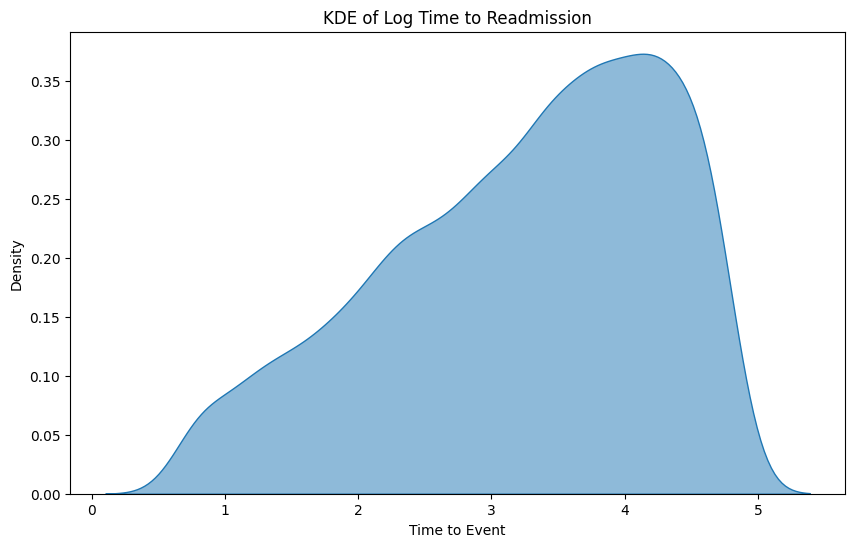

In [109]:
log_duration_readmission_s = np.log1p(all_observed_readmissions_df['EVENT_DURATION'])
plt.figure(figsize=(10, 6))

sns.kdeplot(data=log_duration_readmission_s, alpha=0.5, fill=True)

plt.title('KDE of Log Time to Readmission')
plt.xlabel('Time to Event')
plt.ylabel('Density')
plt.show()

In [110]:
from scipy.stats import normaltest, shapiro
stat_normaltest, p_normaltest = normaltest(log_duration_readmission_s)  # D’Agostino and Pearson’s test
stat_shapiro, p_shapiro = shapiro(log_duration_readmission_s)           # Shapiro-Wilk test

print(f"Normaltest p-value: {p_normaltest}")
print(f"Shapiro-Wilk p-value: {p_shapiro}")

Normaltest p-value: 3.4932758220759655e-78
Shapiro-Wilk p-value: 2.0343943122592748e-35


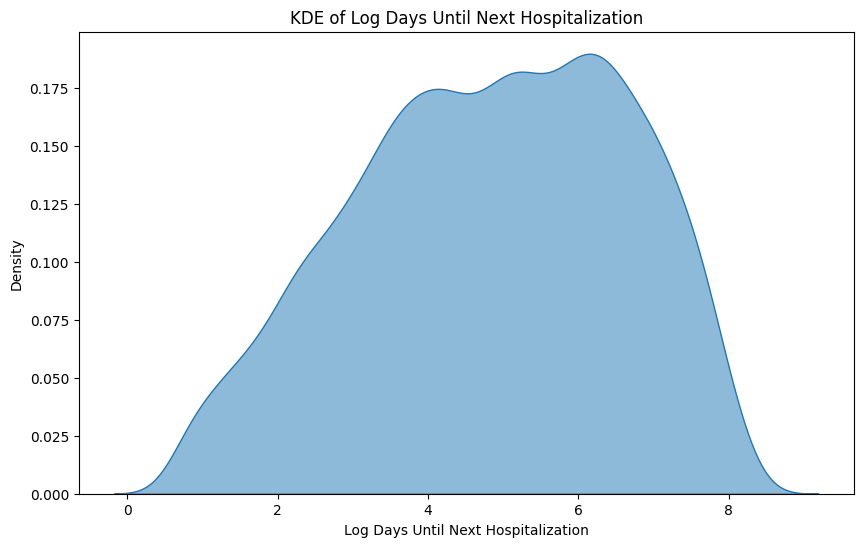

In [111]:
all_events_time_until_next_hosp_df = all_events_df[all_events_df["LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION"].notna()]
plt.figure(figsize=(10, 6))
sns.kdeplot(data=all_events_time_until_next_hosp_df, alpha=0.5, fill=True, x='LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION')
plt.title('KDE of Log Days Until Next Hospitalization')
plt.xlabel('Log Days Until Next Hospitalization')
plt.ylabel('Density')
plt.show()

In [112]:
log_days_until_next_hospitalization_s = all_events_time_until_next_hosp_df["LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION"]

--- Fit Comparison for Log Days Until Next Hospitalization ---


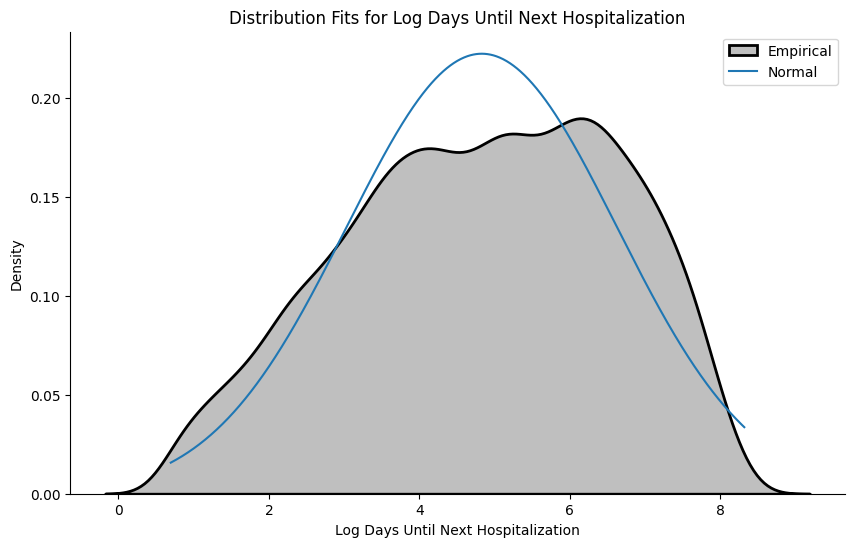

aic           bic        loglik   ks_stat ks_pvalue
normal  36328.992558  36343.216027 -18162.496279  0.051198       0.0

In [113]:
compare_distributions(log_days_until_next_hospitalization_s, 
                      [DistributionType.NORMAL],
                      var_name="Log Days Until Next Hospitalization")

In [114]:
from scipy.stats import normaltest, shapiro
stat_normaltest, p_normaltest = normaltest(log_days_until_next_hospitalization_s)  # D’Agostino and Pearson’s test
stat_shapiro, p_shapiro = shapiro(log_days_until_next_hospitalization_s)           # Shapiro-Wilk test

print(f"Normaltest p-value: {p_normaltest}")
print(f"Shapiro-Wilk p-value: {p_shapiro}")

Normaltest p-value: 1.7173296424387442e-203
Shapiro-Wilk p-value: 2.161342849303121e-35


/home/vscode/poetry-venvs/recurrent-health-events-prediction-nvorhdTT-py3.10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9061.



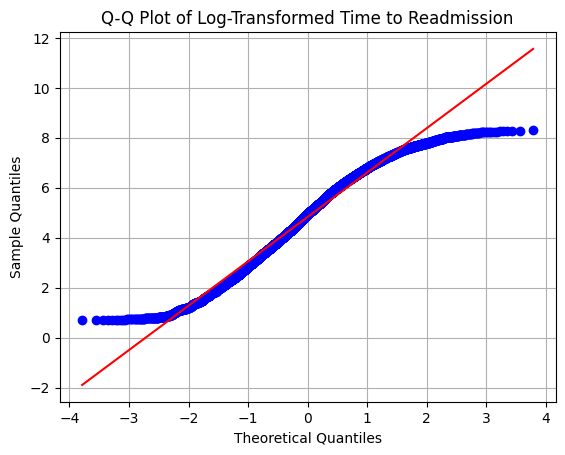

In [115]:
import scipy.stats as stats

stats.probplot(log_days_until_next_hospitalization_s, dist="norm", plot=plt)
plt.title("Q-Q Plot of Log-Transformed Time to Readmission")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

### Distribution of Number of Previous Events

In [116]:
count_all_events_per_subject_df = all_events_df.groupby('SUBJECT_ID').agg(TOTAL_NUM_HOSPITALIZATIONS=('HADM_ID', 'nunique')).reset_index()

In [117]:
event_type_proportions_df = all_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts(normalize=True).rename('Proportion').reset_index()
event_type_counts_df = all_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts().rename('Total Number Events').reset_index()

event_type_proportions_df = event_type_proportions_df.merge(event_type_counts_df, on=('NUM_PREV_HOSPITALIZATIONS', 'EVENT_TYPE'))

fig = px.bar(
       event_type_proportions_df,
       x='NUM_PREV_HOSPITALIZATIONS',
       y='Proportion',
       color='EVENT_TYPE',
       title='Proportion of Event Types by Number of Previous Hospitalizations',
       labels={'Proportion': 'Proportion of Event Type', 'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'EVENT_TYPE': 'Event Type'},
       color_discrete_map=event_type_color_map,
       text='Total Number Events'  # Add text annotations
)
fig.update_layout(
    height=500,
    bargap=0.2,
    xaxis=dict(tickmode='linear', dtick=1)
)

fig.show()


## Last Events

In [118]:
last_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13533 entries, 0 to 13532
Data columns (total 58 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   SUBJECT_ID                            13533 non-null  int64         
 1   HADM_ID                               13533 non-null  int64         
 2   ADMITTIME                             13533 non-null  datetime64[ns]
 3   DISCHTIME                             13533 non-null  datetime64[ns]
 4   ADMISSION_TYPE                        13533 non-null  object        
 5   ETHNICITY                             13533 non-null  object        
 6   DISCHARGE_LOCATION                    13533 non-null  object        
 7   INSURANCE                             13533 non-null  object        
 8   HOSPITALIZATION_DAYS                  13533 non-null  float64       
 9   NUM_COMORBIDITIES                     13533 non-null  int64         
 10

In [119]:
print("Number of subjects: ", last_events_df["SUBJECT_ID"].nunique())
print("Number of events: ", len(last_events_df))

Number of subjects:  13533
Number of events:  13533


### Target Variable Distribution

In [120]:
last_readmissions_observed_df = last_events_df[last_events_df["DAYS_UNTIL_NEXT_HOSPITALIZATION"].notna()]

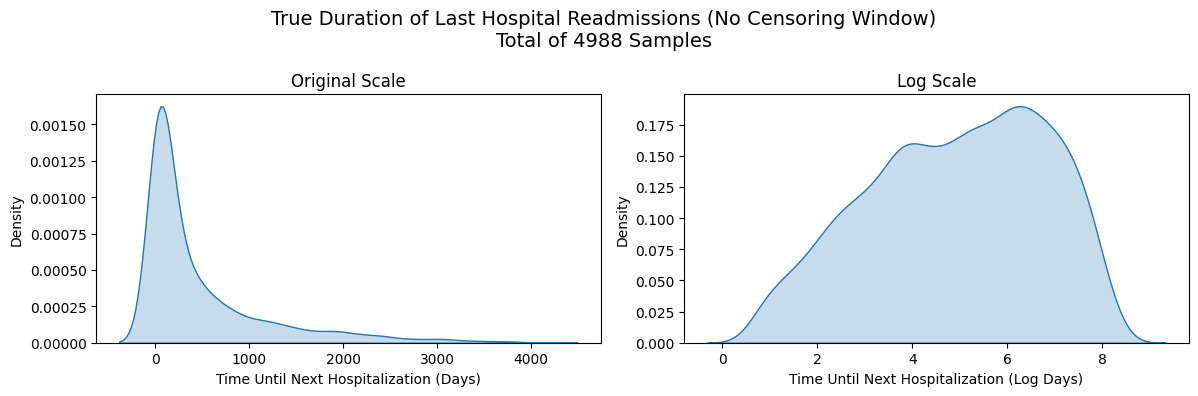

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original plot
sns.kdeplot(last_readmissions_observed_df['DAYS_UNTIL_NEXT_HOSPITALIZATION'], fill=True, ax=axes[0])
axes[0].set_title("Original Scale")
axes[0].set_xlabel("Time Until Next Hospitalization (Days)")
axes[0].set_ylabel("Density")

# Log-transformed plot
sns.kdeplot(np.log1p(last_readmissions_observed_df['DAYS_UNTIL_NEXT_HOSPITALIZATION']), fill=True, ax=axes[1])
axes[1].set_title("Log Scale")
axes[1].set_xlabel("Time Until Next Hospitalization (Log Days)")
axes[1].set_ylabel("Density")
num_samples = len(last_readmissions_observed_df)
plt.suptitle(f"True Duration of Last Hospital Readmissions (No Censoring Window)\nTotal of {len(last_readmissions_observed_df)} Samples", fontsize=14)
plt.tight_layout()
#plt.savefig("last_readmissions_observed_df_kde_plots.png", dpi=500)
plt.show()

In [151]:
import plotly.express as px

mask = (last_events_df["READMISSION_EVENT"] == 1)
fig = px.histogram(
    last_events_df[mask],
    x="EVENT_DURATION",
    title="Distribution of Last Readmission Durations",
    subtitle=f"{len(last_events_df[mask])} samples. Only Readmissions within 120 Days (Non-censored)",
    color_discrete_sequence=px.colors.qualitative.Plotly,
    nbins=120//5,
    range_x=[0, 120],
    width=800,
    height=400
)

fig.update_layout(
    xaxis_title="Readmission Duration (Days)",
    yaxis_title="Number of Readmissions",
    bargap=0.2,
    yaxis={"dtick": 50},
    xaxis={"dtick": 5, "range": [0, 120]}
)
#fig.write_html("last_readmission_duration_distribution.html")
fig.show()

### Distribution of Admisison Type

In [123]:
px.pie(
    last_events_df,
    names="ADMISSION_TYPE",
    title=f"Admission Type Proportions",
    labels={"ADMISSION_TYPE": "Admission Type"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600
).show()

### Distribution of Readmission Time Category

In [124]:
fig = px.pie(
    last_events_df,
    names="READMISSION_TIME_CAT",
    title="Distribution of Readmission Event Time Categories with Censoring - Last Events <br>All. Patients Only",
    labels={"READMISSION_TIME_CAT": "Event Time Category"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=800,
)

# Add values as text labels within the pie chart and set text color to white
fig.update_traces(
    textinfo='percent+value',
    textfont=dict(color='white')
)
fig.update_legends(
    title_text='Readmission Time Category (Days)',
    font=dict(size=12)
)
fig.show()

### Events Types

In [125]:
event_type_proportions_df = last_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts(normalize=True).rename('Proportion').reset_index()
event_type_counts_df = last_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts().rename('Total Number Events').reset_index()

event_type_proportions_df = event_type_proportions_df.merge(event_type_counts_df, on=('NUM_PREV_HOSPITALIZATIONS', 'EVENT_TYPE'))

fig = px.bar(
       event_type_proportions_df,
       x='NUM_PREV_HOSPITALIZATIONS',
       y='Proportion',
       color='EVENT_TYPE',
       title='Proportion of Event Types by Number of Previous Hospitalizations',
       labels={'Proportion': 'Proportion', 'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'EVENT_TYPE': 'Event Type'},
       category_orders={'EVENT_TYPE': ['Readmission after Discharge', 'No Readmission or No Death after Discharge']},
       color_discrete_map=event_type_color_map,
       text='Total Number Events'  # Add text annotations
)
fig.update_layout(height=500, bargap=0.2,
    xaxis=dict(tickmode='linear', dtick=1))  # Position the text at the top of the bars

fig.show()

In [126]:
fig = px.histogram(
    data_frame=last_events_df,
    x='NUM_PREV_HOSPITALIZATIONS',
    color='EVENT_TYPE',
    title='Distribution of Number of Previous Hospitalizations by Event Type',
    color_discrete_map=event_type_color_map,
    barmode='group'
)
fig.show()

### Number of Previous Events

In [127]:
last_events_prev_hosp_per_patient_df = last_events_df.groupby('SUBJECT_ID').first().reset_index()[['SUBJECT_ID', 'NUM_PREV_HOSPITALIZATIONS', 'READMISSION_EVENT']]
value_counts_df = last_events_prev_hosp_per_patient_df[['NUM_PREV_HOSPITALIZATIONS', 'READMISSION_EVENT']].value_counts().reset_index()

In [128]:
last_events_prev_hosp_per_patient_df["label"] = np.where(last_events_prev_hosp_per_patient_df['READMISSION_EVENT'] == 1, 'Readmission within 120 Days', 'No Readmission within 120 Days')
fig = px.histogram(
    last_events_prev_hosp_per_patient_df,
    x='NUM_PREV_HOSPITALIZATIONS',
    facet_col='label',
    title='Count of Num. Prev. Hosp. before Last Readmissions Events',
    labels={'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'label': ''},
    width=800,
    height=400,
    color_discrete_sequence=px.colors.qualitative.Plotly,
)
fig.update_layout(
    yaxis_title='Count',
    bargap=0.05,
)

# Remove '=' from subplot titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
# fig.for_each_yaxis(lambda yaxis: yaxis.update(dtick=50))
fig.for_each_xaxis(lambda xaxis: xaxis.update(dtick=2))


fig.show()

In [129]:
max_num_prev_hosp = last_events_prev_hosp_per_patient_df['NUM_PREV_HOSPITALIZATIONS'].max().item()
print(f"Maximum number of previous hospitalizations: {max_num_prev_hosp}")

Maximum number of previous hospitalizations: 40


In [130]:
count_prev_hosp_s = last_events_prev_hosp_per_patient_df.groupby('NUM_PREV_HOSPITALIZATIONS')["SUBJECT_ID"].count()
count_prev_hosp_s.name = 'Number of Patients'
count_prev_hosp_s

NUM_PREV_HOSPITALIZATIONS
0     11655
1      1003
2       414
3       212
4        96
5        46
6        28
7        24
8        13
9        12
10        8
11        5
12        4
13        1
14        1
15        3
17        1
18        1
19        1
20        1
21        1
22        1
32        1
40        1
Name: Number of Patients, dtype: int64

In [131]:
# compute counts, percent and cumulative percent for number of previous hospitalizations
counts = last_events_prev_hosp_per_patient_df['NUM_PREV_HOSPITALIZATIONS'].value_counts().sort_index()
percent = counts / counts.sum() * 100
cum_percent = percent.cumsum()

cum_df = pd.DataFrame({
    'NUM_PREV_HOSPITALIZATIONS': counts.index,
    'Count': counts.values,
    'Percent (%)': percent.values,
    'Cumulative Percent (%)': cum_percent.values
}).reset_index(drop=True)

cum_df


NUM_PREV_HOSPITALIZATIONS  Count  Percent (%)  Cumulative Percent (%)
0                           0  11655    86.122811               86.122811
1                           1   1003     7.411513               93.534324
2                           2    414     3.059189               96.593512
3                           3    212     1.566541               98.160053
4                           4     96     0.709377               98.869430
5                           5     46     0.339910               99.209340
6                           6     28     0.206902               99.416242
7                           7     24     0.177344               99.593586
8                           8     13     0.096061               99.689648
9                           9     12     0.088672               99.778320
10                         10      8     0.059115               99.837434
11                         11      5     0.036947               99.874381
12                         12      4     0.029557               99.903939
13                         13      1     0.007389               99.911328
14                         14      1     0.007389               99.918717
15                         15      3     0.022168               99.940885
16                         17      1     0.007389               99.948275
17                         18      1     0.007389               99.955664
18                         19      1     0.007389               99.963053
19                         20      1     0.007389               99.970443
20                         21      1     0.007389               99.977832
21                         22      1     0.007389               99.985221
22                         32      1     0.007389               99.992611
23                         40      1     0.007389              100.000000

In [156]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# prepare x and series
x = cum_df['NUM_PREV_HOSPITALIZATIONS'].astype(str)
percent = cum_df['Percent (%)']
cum = cum_df['Cumulative Percent (%)']

# create 1x2 subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cumulative Percent (%)", "Individual Percent (%)"))

# left: cumulative line
fig.add_trace(
    go.Scatter(
        x=x,
        y=cum,
        mode='lines+markers',
        name='Cumulative Percent (%)',
        marker=dict(color=px.colors.qualitative.Plotly[1]),
        line=dict(width=2),
        hovertemplate='%{x}<br>Cumulative: %{y:.2f}%<extra></extra>'
    ),
    row=1, col=1
)

# annotate cumulative values on left
for xi, yi in zip(x, cum):
    if int(xi) > 4:
        continue
    if int(xi) == 4:
        ax_offset = 40
        ay_offset = 20
    else:
        ax_offset = 25
        ay_offset = 25
    fig.add_annotation(
        x=xi, y=yi, xref='x1', yref='y1',
        text=f"{yi:.1f}%", showarrow=True, arrowhead=1, ax=ax_offset, ay=ay_offset, font=dict(size=14)
    )

# right: individual percentages as bars
fig.add_trace(
    go.Bar(
        x=x,
        y=percent,
        name='Percent (%)',
        marker_color=px.colors.qualitative.Plotly[0],
        hovertemplate='%{x}<br>Percent: %{y:.2f}%<extra></extra>',
        textfont=dict(size=14)
    ),
    row=1, col=2
)

# layout and axes
fig.update_yaxes(title_text='Cumulative Percent (%)', range=[50, 100], row=1, col=1)
fig.update_yaxes(title_text='Percent (%)', range=[0, max(100, percent.max() * 1.1)], dtick=10, row=1, col=2)
fig.update_xaxes(title_text='Number of Previous Hospitalizations', row=1, col=1)
fig.update_xaxes(title_text='Number of Previous Hospitalizations', row=1, col=2)

fig.update_layout(
    title='Previous Hospitalizations: Individual and Cumulative Percentages',
    showlegend=False,
    width=1200,
    height=450,
    bargap=0.2,
    margin=dict(t=80, b=50)
)

fig.show()

In [133]:
import numpy as np
import pandas as pd

num_prev_hosp_binned_s = pd.cut(
    last_events_prev_hosp_per_patient_df['NUM_PREV_HOSPITALIZATIONS'], 
    bins=[-1, 0, 1, 2, 3, 4, 8, 12, np.inf], 
    labels=['0', '1', '2', '3', '4', '[5;8]', '[9,12]', 'more than 12'],
    right=True
).value_counts(normalize=True).sort_index()*100

num_prev_hosp_binned_s = num_prev_hosp_binned_s.rename_axis('Number of Previous Hospitalizations').reset_index(name='Proportion (%)')
num_prev_hosp_binned_s

Number of Previous Hospitalizations  Proportion (%)
0                                   0       86.122811
1                                   1        7.411513
2                                   2        3.059189
3                                   3        1.566541
4                                   4        0.709377
5                               [5;8]        0.820217
6                              [9,12]        0.214291
7                        more than 12        0.096061

### Diseases at Last Readmissions Events

In [134]:
num_comorbidities_binned_s = pd.cut(
    last_events_df['NUM_COMORBIDITIES'],
    bins=[0, 1, 2, 3, 4, np.inf],
    labels=['1', '2', '3', '4', 'more than 4'],
    right=True,
).value_counts(normalize=True).sort_index() * 100

num_comorbidities_binned_s = num_comorbidities_binned_s.rename_axis('Number of Comorbidities').reset_index(name='Proportion (%)')
num_comorbidities_binned_s

Number of Comorbidities  Proportion (%)
0                       1        1.995123
1                       2       25.256780
2                       3       33.281608
3                       4       23.727185
4             more than 4       15.739304

In [135]:
fig = px.histogram(
    last_events_df,
    x="NUM_COMORBIDITIES",
    title="Distribution of Number of Comorbidities - Last Readmission Events",
    width=800,
    height=400,
    nbins=50,
)
fig.update_layout(xaxis_title="Number of Comorbidities", yaxis_title="Count")
fig.show()

In [136]:
diseases_last_readmissions_df = last_events_df[['SUBJECT_ID', 'TYPES_COMORBIDITIES']].copy()
diseases_last_readmissions_df.head()

SUBJECT_ID                                TYPES_COMORBIDITIES
0           6                         ['other', 'renal_disease']
1          21  ['myocardial_infarct', 'other', 'cerebrovascul...
2          26  ['other', 'congestive_heart_failure', 'myocard...
3          28  ['other', 'diabetes_without_cc', 'myocardial_i...
4          30              ['other', 'congestive_heart_failure']

In [137]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# If your column is still strings, convert to list first
diseases_last_readmissions_df['TYPES_COMORBIDITIES'] = diseases_last_readmissions_df['TYPES_COMORBIDITIES'].apply(ast.literal_eval)

# Now one-hot encode the comorbidities
mlb = MultiLabelBinarizer()
disease_ohe = mlb.fit_transform(diseases_last_readmissions_df['TYPES_COMORBIDITIES'])

# Create a DataFrame with patient IDs as index and disease columns
disease_df = pd.DataFrame(disease_ohe, 
                          columns=mlb.classes_, 
                          index=diseases_last_readmissions_df['SUBJECT_ID'])

# Now you can see the matrix you described
disease_df.head()

aids  cerebrovascular_disease  chronic_pulmonary_disease  \
SUBJECT_ID                                                             
6              0                        0                          0   
21             0                        1                          0   
26             0                        0                          0   
28             0                        0                          1   
30             0                        0                          0   

            congestive_heart_failure  dementia  diabetes_with_cc  \
SUBJECT_ID                                                         
6                                  0         0                 0   
21                                 1         0                 0   
26                                 1         0                 0   
28                                 0         0                 0   
30                                 1         0                 0   

            diabetes_without_cc  malignant_cancer  metastatic_solid_tumor  \
SUBJECT_ID                                                                  
6                             0                 0                       0   
21                            1                 0                       0   
26                            0                 0                       0   
28                            1                 0                       0   
30                            0                 0                       0   

            mild_liver_disease  myocardial_infarct  other  paraplegia  \
SUBJECT_ID                                                              
6                            0                   0      1           0   
21                           0                   1      1           0   
26                           0                   1      1           0   
28                           0                   1      1           0   
30                           0                   0      1           0   

            peptic_ulcer_disease  peripheral_vascular_disease  renal_disease  \
SUBJECT_ID                                                                     
6                              0                            0              1   
21                             0                            0              1   
26                             0                            0              0   
28                             0                            0              0   
30                             0                            0              0   

            rheumatic_disease  severe_liver_disease  
SUBJECT_ID                                           
6                           0                     0  
21                          0                     0  
26                          0                     0  
28                          0                     0  
30                          0                     0

In [138]:
disease_counts = disease_df.sum().sort_values(ascending=False)
labels = disease_counts.index.tolist()
alias = [label.replace('_', ' ').title().replace('Cc', 'CC') for label in labels]

In [139]:
dict(zip(labels, alias))

{'other': 'Other',
 'congestive_heart_failure': 'Congestive Heart Failure',
 'chronic_pulmonary_disease': 'Chronic Pulmonary Disease',
 'diabetes_without_cc': 'Diabetes Without CC',
 'renal_disease': 'Renal Disease',
 'myocardial_infarct': 'Myocardial Infarct',
 'peripheral_vascular_disease': 'Peripheral Vascular Disease',
 'diabetes_with_cc': 'Diabetes With CC',
 'cerebrovascular_disease': 'Cerebrovascular Disease',
 'malignant_cancer': 'Malignant Cancer',
 'mild_liver_disease': 'Mild Liver Disease',
 'rheumatic_disease': 'Rheumatic Disease',
 'metastatic_solid_tumor': 'Metastatic Solid Tumor',
 'peptic_ulcer_disease': 'Peptic Ulcer Disease',
 'severe_liver_disease': 'Severe Liver Disease',
 'paraplegia': 'Paraplegia',
 'aids': 'Aids',
 'dementia': 'Dementia'}

In [140]:
disease_counts = disease_df.sum().sort_values(ascending=False)
labels = disease_counts.index.tolist()
alias = [label.replace('_', ' ').title().replace('Cc', 'CC') for label in labels]
alias_mapping = dict(zip(labels, alias))

fig = px.bar(disease_counts,
    title='Total Number of Patients with Each Disease',
    subtitle='Last Readmissions Events',
    labels={'index': 'Disease', 'value': 'Number of Patients'},
    width=1200,
    height=400
).update_layout(
    xaxis_title='Disease',
    yaxis_title='Number of Patients',
    yaxis={"dtick": 1500},
    showlegend=False
).update_xaxes(labelalias=alias_mapping)

fig.write_html("disease_counts_last_readmissions.html")
fig.show()


In [141]:
diseases_counts_df = disease_counts.reset_index().rename(columns={'index': 'Disease', 0: 'Number of Patients'})
diseases_counts_df['Percent of Patients'] = diseases_counts_df['Number of Patients'] / diseases_last_readmissions_df['SUBJECT_ID'].nunique() * 100
diseases_counts_df

Disease  Number of Patients  Percent of Patients
0                         other               13515            99.866992
1      congestive_heart_failure                6860            50.690904
2     chronic_pulmonary_disease                6084            44.956772
3           diabetes_without_cc                3612            26.690313
4                 renal_disease                3418            25.256780
5            myocardial_infarct                2935            21.687726
6   peripheral_vascular_disease                1778            13.138255
7              diabetes_with_cc                1469            10.854947
8       cerebrovascular_disease                1350             9.975615
9              malignant_cancer                1092             8.069164
10           mild_liver_disease                1008             7.448459
11            rheumatic_disease                 441             3.258701
12       metastatic_solid_tumor                 382             2.822730
13         peptic_ulcer_disease                 335             2.475430
14         severe_liver_disease                 309             2.283307
15                   paraplegia                 250             1.847336
16                         aids                 105             0.775881
17                     dementia                  70             0.517254

## Historical Events EDA

### Inspect Patient Past Events

In [142]:
plot_patients_hospitalizations(
    historical_events_df,
    subject_ids=[323, 357, 402, 433, 518],
    additional_hover_cols=[
        "EVENT_TYPE",
        "DAYS_UNTIL_NEXT_HOSPITALIZATION",
        "TYPES_COMORBIDITIES",
        "ADMISSION_TYPE",
        "TOTAL_HOSPITALIZATIONS",
    ],
    color_map=event_type_color_map,
    color_col="EVENT_TYPE",
)

In [143]:
subject_id = 323
mask = (all_events_df["SUBJECT_ID"] == subject_id)
print("All events of patient with SUBJECT_ID = ", subject_id)
all_events_df[mask]

All events of patient with SUBJECT_ID =  323


SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
104         323   192631 2115-05-17 21:06:00 2115-05-27 13:30:00   
105         323   106158 2116-05-03 23:07:00 2116-05-11 13:37:00   
106         323   128132 2119-09-21 20:34:00 2119-10-06 18:50:00   

    ADMISSION_TYPE ETHNICITY        DISCHARGE_LOCATION INSURANCE  \
104      EMERGENCY     WHITE       SHORT TERM HOSPITAL  Medicare   
105      EMERGENCY     WHITE          HOME HEALTH CARE  Medicare   
106      EMERGENCY     WHITE  REHAB/DISTINCT PART HOSP  Medicare   

     HOSPITALIZATION_DAYS  NUM_COMORBIDITIES  ... LOG_HOSPITALIZATION_DAYS  \
104              9.683333                  5  ...                 2.368685   
105              7.604167                  4  ...                 2.152247   
106             14.927778                  4  ...                 2.768065   

     LOG_DAYS_IN_ICU  LOG_NUM_PREV_HOSPITALIZATIONS  LOG_PARTICIPATION_DAYS  \
104         1.423777                       0.000000                2.302585   
105         1.692297                       0.693147                5.886104   
106         2.564941                       1.098612                7.379632   

    LOG_NUM_DRUGS  IS_LAST_EVENT IS_HISTORICAL_EVENT READMISSION_TIME_CAT  \
104      0.000000              0                   1                 120+   
105      0.000000              0                   1                 120+   
106      3.912023              1                   0               30-120   

     READMISSION_TIME_CAT_ENCODED  \
104                             2   
105                             2   
106                             1   

                                            EVENT_TYPE  
104  Hosp. with No Readmission or No Death after Di...  
105  Hosp. with No Readmission or No Death after Di...  
106             Hosp. with Readmission after Discharge  

[3 rows x 58 columns]

In [144]:
print("Last events of patient with SUBJECT_ID = ", subject_id)
mask = (last_events_df["SUBJECT_ID"] == subject_id)
last_events_df[mask]

Last events of patient with SUBJECT_ID =  323


SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
84         323   128132 2119-09-21 20:34:00 2119-10-06 18:50:00   

   ADMISSION_TYPE ETHNICITY        DISCHARGE_LOCATION INSURANCE  \
84      EMERGENCY     WHITE  REHAB/DISTINCT PART HOSP  Medicare   

    HOSPITALIZATION_DAYS  NUM_COMORBIDITIES  ... LOG_HOSPITALIZATION_DAYS  \
84             14.927778                  4  ...                 2.768065   

    LOG_DAYS_IN_ICU  LOG_NUM_PREV_HOSPITALIZATIONS  LOG_PARTICIPATION_DAYS  \
84         2.564941                       1.098612                7.379632   

   LOG_NUM_DRUGS  IS_LAST_EVENT IS_HISTORICAL_EVENT READMISSION_TIME_CAT  \
84      3.912023              1                   0               30-120   

    READMISSION_TIME_CAT_ENCODED                              EVENT_TYPE  
84                             1  Hosp. with Readmission after Discharge  

[1 rows x 58 columns]

In [145]:
mask = (last_events_df['READMISSION_EVENT'] == 1)
last_events_df[mask]

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
15             68   170467 2173-12-15 16:16:00 2174-01-03 18:30:00   
18            105   161160 2189-01-28 16:57:00 2189-02-02 16:40:00   
25            130   198214 2119-10-29 14:49:00 2119-11-05 17:00:00   
29            138   188284 2133-12-21 23:52:00 2134-01-11 13:00:00   
36            157   110545 2106-05-17 10:59:00 2106-05-26 16:15:00   
...           ...      ...                 ...                 ...   
13494       99538   194801 2180-02-13 17:46:00 2180-02-26 15:35:00   
13500       99562   129689 2183-02-02 15:13:00 2183-02-18 13:28:00   
13502       99613   175391 2152-11-03 18:12:00 2152-11-14 15:43:00   
13525       99923   164914 2201-02-23 20:42:00 2201-03-03 16:00:00   
13531       99982   112748 2157-01-05 17:27:00 2157-01-12 13:00:00   

      ADMISSION_TYPE               ETHNICITY        DISCHARGE_LOCATION  \
15         EMERGENCY  BLACK/AFRICAN AMERICAN          HOME HEALTH CARE   
18         EMERGENCY  BLACK/AFRICAN AMERICAN                      HOME   
25         EMERGENCY                   WHITE          HOME HEALTH CARE   
29         EMERGENCY                   WHITE                      HOME   
36         EMERGENCY                   WHITE  REHAB/DISTINCT PART HOSP   
...              ...                     ...                       ...   
13494      EMERGENCY                   WHITE                       SNF   
13500         URGENT                   WHITE                       SNF   
13502      EMERGENCY                   WHITE   LONG TERM CARE HOSPITAL   
13525      EMERGENCY                   WHITE                      HOME   
13531      EMERGENCY                   WHITE                      HOME   

      INSURANCE  HOSPITALIZATION_DAYS  NUM_COMORBIDITIES  ...  \
15     Medicare             19.093056                  4  ...   
18     Medicare              4.988194                  2  ...   
25      Private              7.090972                  4  ...   
29      Private             20.547222                  3  ...   
36     Medicare              9.219444                  3  ...   
...         ...                   ...                ...  ...   
13494  Medicare             12.909028                  5  ...   
13500  Medicare             15.927083                  5  ...   
13502  Medicare             10.896528                  2  ...   
13525   Private              7.804167                  4  ...   
13531  Medicare              6.814583                  3  ...   

      LOG_HOSPITALIZATION_DAYS  LOG_DAYS_IN_ICU  \
15                    3.000374         1.678368   
18                    1.789790         1.791223   
25                    2.090749         1.534797   
29                    3.070247         1.603159   
36                    2.324292         1.119114   
...                        ...              ...   
13494                 2.632538         2.394450   
13500                 2.828915         1.122092   
13502                 2.476247         1.043853   
13525                 2.175225         0.559464   
13531                 2.055992         1.782165   

       LOG_NUM_PREV_HOSPITALIZATIONS  LOG_PARTICIPATION_DAYS LOG_NUM_DRUGS  \
15                          0.000000                2.995732      4.189655   
18                          0.000000                1.609438      3.091042   
25                          0.000000                2.079442      3.912023   
29                          0.693147                6.689599      3.784190   
36                          0.000000                2.302585      3.688879   
...                              ...                     ...           ...   
13494                       0.000000                2.564949      4.262680   
13500                       0.000000                2.772589      3.951244   
13502                       0.000000                2.397895      3.713572   
13525                       0.000000                2.079442      3.091042   
13531                    

### Num Historical Events per Patient

In [146]:
events_count = historical_events_df.groupby('SUBJECT_ID').size().reset_index(name='EVENT_COUNT')

# Group by Event Count and count the number of patients
event_count_distribution = events_count['EVENT_COUNT'].value_counts().sort_index()

# Plot the bar chart with all ticks on the x-axis
fig = px.bar(
    event_count_distribution,
    x=event_count_distribution.index,
    y=event_count_distribution.values,
    title='Distribution of Number of Historical Readmission Events per Patient',
    subtitle=f'All Patients({len(events_count)} patients, {len(historical_events_df)} Events, Max. {events_count["EVENT_COUNT"].max()} Events per Patient)',
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title='Number of Readmissions',
    yaxis_title='Number of Patients',
    xaxis=dict(tickmode='linear', dtick=1),  # Ensure all ticks are displayed
    yaxis=dict(tickmode='linear', dtick=100)  # Ensure all ticks are displayed
)
fig.write_html("num_historical_readmission_events_distribution.html")
fig.show()

### Maximum Gap Time Between Events

In [147]:
historical_events_df.head()

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
8           36   182104 2131-04-30 07:15:00 2131-05-08 14:00:00   
20         107   191941 2115-02-20 17:41:00 2115-02-21 16:30:00   
25         124   172461 2160-06-24 21:25:00 2160-07-15 15:10:00   
26         124   112906 2161-12-17 03:39:00 2161-12-24 15:35:00   
33         138   108120 2131-10-31 08:00:00 2131-11-06 12:54:00   

   ADMISSION_TYPE           ETHNICITY DISCHARGE_LOCATION INSURANCE  \
8       EMERGENCY               WHITE   HOME HEALTH CARE  Medicare   
20      EMERGENCY  HISPANIC OR LATINO               HOME   Private   
25      EMERGENCY               WHITE   HOME HEALTH CARE   Private   
26      EMERGENCY               WHITE               HOME  Medicare   
33       ELECTIVE               WHITE               HOME   Private   

    HOSPITALIZATION_DAYS  NUM_COMORBIDITIES  ... LOG_HOSPITALIZATION_DAYS  \
8               8.281250                  2  ...                 2.227996   
20              0.950694                  2  ...                 0.668185   
25             20.739583                  3  ...                 3.079135   
26              7.497222                  3  ...                 2.139739   
33              6.204167                  4  ...                 1.974660   

    LOG_DAYS_IN_ICU  LOG_NUM_PREV_HOSPITALIZATIONS  LOG_PARTICIPATION_DAYS  \
8          0.746496                       0.000000                2.197225   
20         0.702404                       0.000000                0.693147   
25         1.591651                       0.000000                3.044522   
26         2.102874                       0.693147                6.306275   
33         0.677311                       0.000000                1.945910   

   LOG_NUM_DRUGS  IS_LAST_EVENT IS_HISTORICAL_EVENT READMISSION_TIME_CAT  \
8       3.951244              0                   1                 0-30   
20      2.397895              0                   1                 120+   
25      3.663562              0                   1                 120+   
26      3.637586              0                   1                 120+   
33      3.688879              0                   1                 120+   

    READMISSION_TIME_CAT_ENCODED  \
8                              0   
20                             2   
25                             2   
26                             2   
33                             2   

                                           EVENT_TYPE  
8              Hosp. with Readmission after Discharge  
20  Hosp. with No Readmission or No Death after Di...  
25  Hosp. with No Readmission or No Death after Di...  
26  Hosp. with No Readmission or No Death after Di...  
33  Hosp. with No Readmission or No Death after Di...  

[5 rows x 58 columns]

In [148]:
historical_events_df['MAX_TIME_TO_RETURN_TO_HOSP'] = historical_events_df.groupby('SUBJECT_ID')['DAYS_UNTIL_NEXT_HOSPITALIZATION'].transform(lambda x: x.max())

In [149]:
max_gap_df = historical_events_df[['SUBJECT_ID', 'MAX_TIME_TO_RETURN_TO_HOSP']].groupby('SUBJECT_ID').first().reset_index()

In [150]:
import plotly.express as px

# Define the color
plotly_colors = px.colors.qualitative.Plotly

# Create the histogram
fig = px.histogram(
    max_gap_df,
    x="MAX_TIME_TO_RETURN_TO_HOSP",
    title="Maximum Readmission Interval for Patients - Historical Records",
    subtitle=f"All Patients({len(max_gap_df)} patients, {len(historical_events_df)} events)",
    labels={"MAX_TIME_TO_RETURN_TO_HOSP": "Max Time to Return to Hospital (days)"},
    color_discrete_sequence=[plotly_colors[0]],
    nbins=50,
    width=1200,
    height=400
)

# Update layout
fig.update_layout(
    xaxis_title="Maximum Time to Return to Hospital (Days)",
    yaxis_title="Number of Patients",
    yaxis={"dtick": 50},
    bargap=0.2,
    xaxis=dict(
        tickmode='linear',
        dtick=100,
        tickangle=45,
        range=[0, max_gap_df["MAX_TIME_TO_RETURN_TO_HOSP"].max() + 10]
    ),
)

#fig.write_html("max_time_to_return_to_hospital_histogram.html")
# Show the plot
fig.show()